In [65]:
import torch
from torch.utils import data
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from unet import UNet
from diffusion import GaussianDiffusion, Trainer

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16

## Dataloader

In [2]:
import os
import random

class Dataset(data.Dataset):
    def __init__(self, folder, image_size, mode):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.mode = mode
        self.data_files = [self.folder +"test/"+ f for f in os.listdir(self.folder+"test/") if os.path.isfile(os.path.join(self.folder+"test/", f))]


        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
        ])

        
    def __len__(self):
        dir_path = self.folder+"test/"
        res = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
        return res
    
    def irregular_mask(self, data, rate=0.5):
        """the mask matrix of random sampling
        Args:
            data: original data patches
            rate: sampling rate,range(0,1)
        """
        n = data.size()[-1]
        mask = torch.torch.zeros(data.size(),dtype=torch.float64)
        
        v = round(n*rate)
        TM = random.sample(range(n),v)
        mask[:,:,TM]=1 # missing by column 
        mask = mask.type(torch.HalfTensor)
        return  mask

    def __getitem__(self, index):
        # data = self.folder+"data/"+str(index)+".png"
        data = self.data_files[index]
        img_data = Image.open(data)

        if self.mode == "demultiple":

            return self.transform(img_data)
        elif self.mode == "interpolation":
            return self.irregular_mask(self.transform(img_data)), self.transform(img_data)
        elif self.mode == "denoising":
            img = self.transform(img_data)
            mean = torch.mean(img)
            std = torch.std(img)
            noise = 0.5*torch.normal(mean, std, size =(img.shape[0], img.shape[1], img.shape[2]))
            img_ = img + noise
            
            return img
        

        else:
            print("ERROR MODE")

## Create Model

In [3]:
mode = "demultiple" #demultiple, interpolation, denoising
folder = './dataset/'+mode+'/data_train/'

image_size = (256,256)
    
model = UNet(
        in_channel=2,
        out_channel=1
).cuda()

diffusion = GaussianDiffusion(
    model,
    mode = mode,
    channels = 1,
    image_size = image_size,
    timesteps = 2000,
    loss_type = 'l1', # L1 or L2
).cuda()

ds = Dataset(folder, image_size=image_size, mode=mode)

## Load Model

In [4]:
parameters = torch.load("/home/lty/MyProjects/diffseis/results_demultiple/model-350.pt")['model']

del parameters['betas']
del parameters['alphas_cumprod']
del parameters['alphas_cumprod_prev']
del parameters['sqrt_alphas_cumprod']
del parameters['sqrt_one_minus_alphas_cumprod']
del parameters['log_one_minus_alphas_cumprod']
del parameters['sqrt_recip_alphas_cumprod']
del parameters['sqrt_recipm1_alphas_cumprod']
del parameters['posterior_variance']
del parameters['posterior_log_variance_clipped']
del parameters['posterior_mean_coef1']
del parameters['posterior_mean_coef2']


def change_key(self, old, new):
    #copy = self.copy()
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v
        
keys = []
for key, value in parameters.items():
    keys.append(key)

for i in range(len(keys)):
    change_key(parameters, keys[i], keys[i][11:])

model.load_state_dict(parameters)

<All keys matched successfully>

In [52]:
num = 10
in_samples = np.zeros([num,image_size[0],image_size[1]])
out_samples = np.zeros([num,image_size[0],image_size[1]])

for i, (x_in) in enumerate(ds):
    x_start = x_in[0]
    # x_start = torch.stack((x_start, x_start), dim=0)
    x_start = torch.unsqueeze(x_start, dim=0)
    x_start = torch.unsqueeze(x_start, dim=0)
    print(x_start.shape)
    # x_ = x_in[1]
    # x_ = torch.unsqueeze(x_, dim=0)

    if mode == "interpolation":
        out = diffusion.inference(x_in=x_.cuda(), mask=x_start.cuda())
    else:
        out = diffusion.inference(x_in=x_start.cuda())

    in_samples[i] = out[0,0].cpu().detach().numpy()
    out_samples[i] = out[1,0].cpu().detach().numpy()
    if mode == "interpolation":
        out_samples[i] = out[2,0].cpu().detach().numpy()
    
    if i == num-1:
        break

torch.Size([1, 1, 256, 256])


sampling loop time step:   0%|          | 0/2000 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 2000/2000 [00:53<00:00, 37.12it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:54<00:00, 36.47it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:55<00:00, 36.34it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:54<00:00, 36.37it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:55<00:00, 36.26it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:55<00:00, 36.31it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:54<00:00, 36.37it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:55<00:00, 36.32it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:55<00:00, 36.30it/s]


torch.Size([1, 1, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:55<00:00, 36.31it/s]


## Plotting

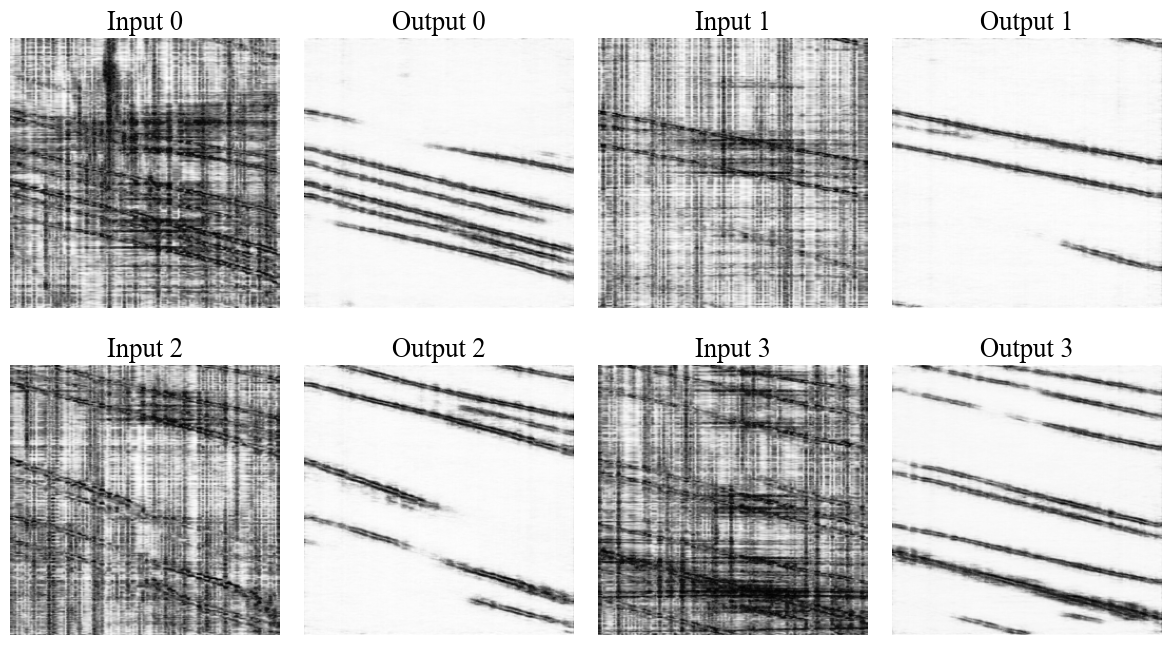

In [67]:
num = 10

fig, axs = plt.subplots(2, 4, figsize=(12,7))
# axs = axs.ravel()
axs = axs.flatten()

max_ = x_start.max()
min_ = x_start.min()
cont = 0
for i in range(4):
    axs[cont].imshow(in_samples[i], cmap="Greys_r")
    axs[cont].set_title("Input "+str(i))
    cont = cont+1
    axs[cont].imshow(out_samples[i], cmap="Greys_r")
    axs[cont].set_title("Output "+str(i))
    cont = cont+1
[axi.set_axis_off() for axi in axs.ravel()]
fig.tight_layout()

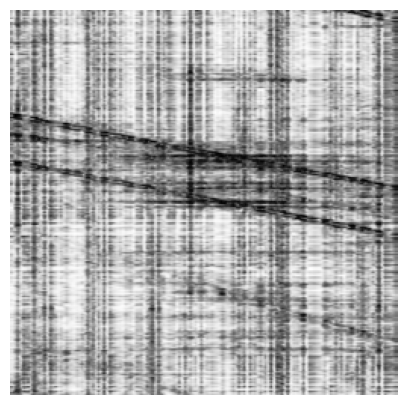

In [50]:
fig_size = (5,5)

fig, ax = plt.subplots(1,1, figsize=fig_size)

ax.imshow(in_samples[i], cmap="Greys_r", aspect="auto")
ax.set_axis_off()
ax.axis("off")
ax.margins(0)

# fig.savefig("inference.png", bbox_inches='tight', pad_inches=0)

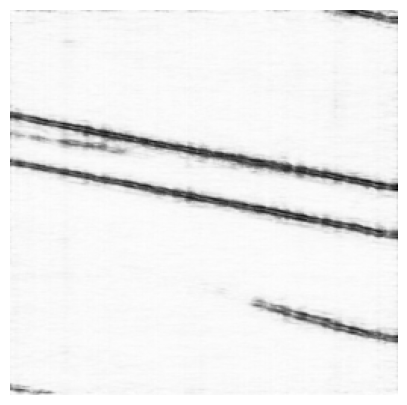

In [39]:
fig_size = (5,5)

fig, ax = plt.subplots(1,1, figsize=fig_size)

ax.imshow(out_samples[i], cmap="Greys_r", aspect="auto")
ax.set_axis_off()

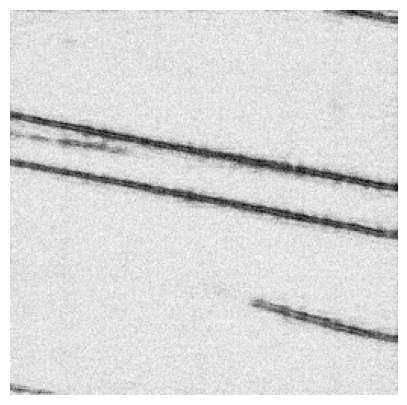

In [40]:
noise = np.random.randn(256,256)/10.

fig, ax = plt.subplots(1,1, figsize=fig_size)

ax.imshow(noise+out_samples[i], cmap="Greys_r", aspect="auto")
ax.set_axis_off()

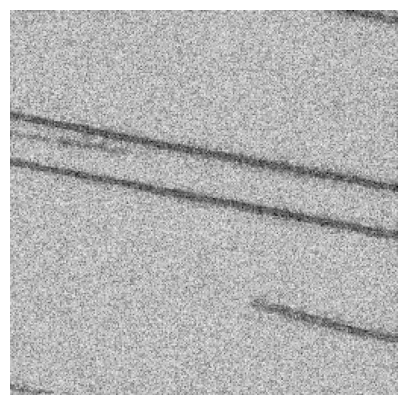

In [41]:
noise2 = np.random.randn(256,256)/3.

fig, ax = plt.subplots(1,1, figsize=fig_size)

ax.imshow(noise+noise2+out_samples[i], cmap="Greys_r", aspect="auto")
ax.set_axis_off()

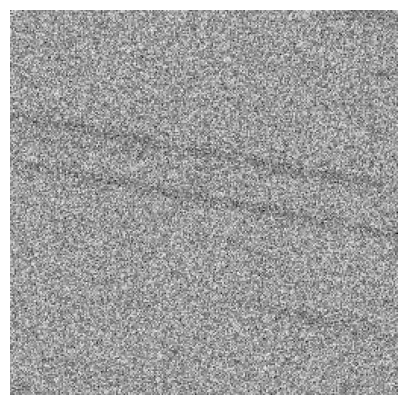

In [42]:
noise3 = np.random.randn(256,256)*2

fig, ax = plt.subplots(1,1, figsize=fig_size)

ax.imshow(noise+noise2+noise3+out_samples[i], cmap="Greys_r", aspect="auto")
ax.set_axis_off()

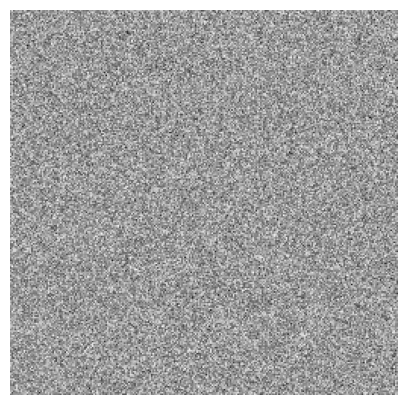

In [44]:
fig, ax = plt.subplots(1,1, figsize=fig_size)
ax.imshow(noise, cmap="Greys_r", aspect="auto")
ax.set_axis_off()

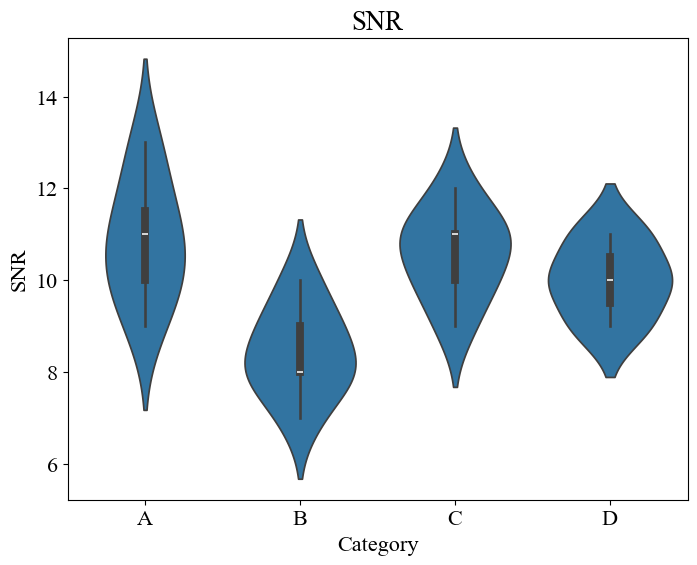

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 示例数据
data = {
    'Category': ['A', 'B', 'C', 'D'],
    'SNR': [
        [10, 11, 9, 12, 13, 10, 11],
        [8, 9, 10, 8, 7, 8, 9],
        [11, 12, 11, 10, 9, 11, 10],
        [9, 10, 11, 9, 10, 10, 11]
    ]
}

# 转换数据格式
df = pd.DataFrame({
    'Category': sum([[c]*len(s) for c, s in zip(data['Category'], data['SNR'])], []),
    'SNR': sum(data['SNR'], [])
})

# 绘制小提琴图
plt.figure(figsize=(8, 6))
sns.violinplot(x='Category', y='SNR', data=df)
plt.title('SNR')
plt.show()


In [69]:
df


,Category,SNR
0,A,10
1,A,11
2,A,9
3,A,12
4,A,13
5,A,10
6,A,11
7,B,8
8,B,9
9,B,10
